In [81]:
import warnings
from urllib3.exceptions import NotOpenSSLWarning

warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

In [82]:
import string
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
import numpy as np
import utility_functions as utils
import importlib
import pandas as pd
import seaborn as sns

# Text processing
from gensim import corpora, models
from gensim.models import CoherenceModel

# Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

# Octis is the library which can use different implemented topic modelling techniques
from octis.preprocessing.preprocessing import Preprocessing
from octis.evaluation_metrics.coherence_metrics import Coherence
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.models.CTM import CTM

importlib.reload(utils)

data = './preprocessed_df.pkl'

In [83]:
df = pd.read_pickle(data)
df[['Artist', 'Song', 'Tokens', 'Lyrics', 'Coast']].head()

,Artist,Song,Tokens,Lyrics,Coast
0,Big L,8 Iz Enuff.mp3,"[crew, house, terra, herb, mcgruff, buddah, bl...","\n\nYo\nMy crew is in the house\nTerra, Herb M...",east_coast
1,Big L,Da Graveyard.mp3,"[number, one, crew, area, big, lightin, nigga,...",\n\n[Intro:]\nIt's the number one crew in the ...,east_coast
2,Big L,I Don't Understand It.mp3,"[many, mc, overrate, ask, even, suppose, make,...",\n\n[Verse 1]\nThere are too many MC's who are...,east_coast
3,Big L,"No Endz, No Skinz.mp3","[let, get, point, real, quick, pocket, thick, ...",\n\n[Verse 1:]\nLet me get to the point real q...,east_coast
4,Big L,MVP.mp3,"[spark, phillies, pass, stout, making, quick, ...",\n\n[Big L]\n A yo spark up the phillies and p...,east_coast


In [84]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['Tokens'])
dictionary.filter_extremes(no_below=5, no_above=0.5)
print(f"Number of unique tokens: {len(dictionary)}")

Number of unique tokens: 5609


In [85]:
# Convert documents to a bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

In [86]:
from tqdm import tqdm
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []

    # Add tqdm for progress tracking
    for num_topics in tqdm(range(start, limit, step), desc="Computing coherence"):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            chunksize=chunksize,
            passes=passes,
            iterations=iterations,
            alpha='auto',
            eta='auto',
            eval_every=eval_every
        )
        model_list.append(model)

        # Applies a sliding window and evaluates similarity of the top words in each topic. 
        coherencemodel = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [87]:
start = 2
limit = 6
step = 1

model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=df['Tokens'],
    start=start,
    limit=limit,
    step=step
)

Computing coherence:   0%|          | 0/4 [00:00<?, ?it/s]/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/borosabel/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is com

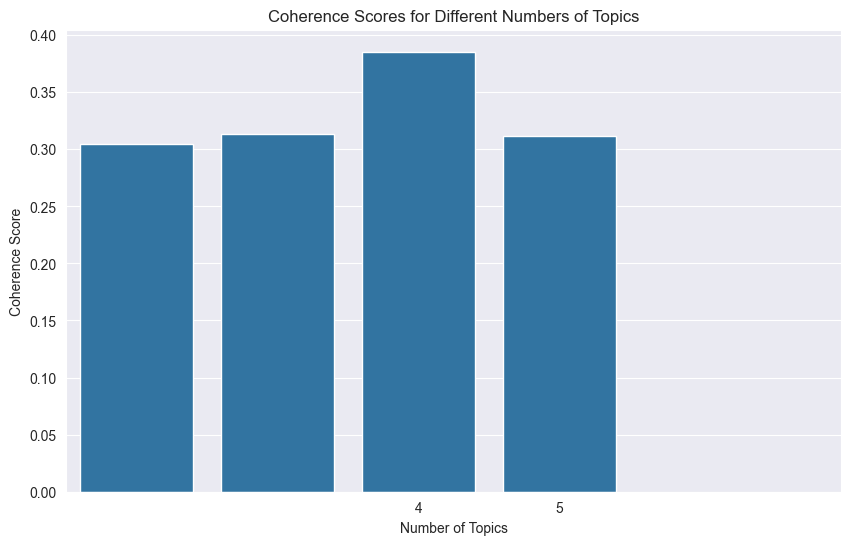

In [88]:
# Prepare data for Seaborn
x = list(range(start, limit, step))

# Create a barplot with Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=x, y=coherence_values)

# Set plot labels and title
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")

# Ensure integer values on the x-axis
plt.xticks(ticks=x)

plt.show()

In [89]:
# Select the model with highest coherence
optimal_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_index]
optimal_num_topics = x[optimal_index]

print(f'Optimal Number of Topics: {optimal_num_topics}')
print(f'Highest Coherence Score: {coherence_values[optimal_index]:.4f}')

Optimal Number of Topics: 4
Highest Coherence Score: 0.3854


In [90]:
# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

In [97]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        # Get the dominant topic, its percentage, and keywords
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Only the dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])

                # Creating a temporary DataFrame to hold the new row
                temp_df = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]],
                                       columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

                # Use pd.concat() instead of append
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)

            else:
                break

    # Add original text to the DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Text')], axis=1)

    return sent_topics_df

# Apply the updated function
df_topic_sents_keywords = format_topics_sentences(
    ldamodel=optimal_model,
    corpus=corpus,
    texts=df['Lyrics']
)

# Format the output
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Display the result
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5879,"fuck, as, motherfucker, street, hit, real, put...","\n\nYo\nMy crew is in the house\nTerra, Herb M..."
1,1,0,0.7586,"fuck, as, motherfucker, street, hit, real, put...",\n\n[Intro:]\nIt's the number one crew in the ...
2,2,0,0.3500,"fuck, as, motherfucker, street, hit, real, put...",\n\n[Verse 1]\nThere are too many MC's who are...
3,3,3,0.4747,"love, would, girl, way, tell, brother, u, need...",\n\n[Verse 1:]\nLet me get to the point real q...
4,4,3,0.3867,"love, would, girl, way, tell, brother, u, need...",\n\n[Big L]\n A yo spark up the phillies and p...


In [98]:
# Assuming you have a 'Region' column indicating 'East' or 'West'
df_dominant_topic['Coast'] = df['Coast']

# Calculate the distribution of topics by region (East vs West) in percentages
topic_region_dist = pd.crosstab(df_dominant_topic['Dominant_Topic'],
                                df_dominant_topic['Coast'],
                                normalize='index') * 100
print(topic_region_dist)

Coast           east_coast  west_coast
Dominant_Topic                        
0                36.092715   63.907285
1                72.682927   27.317073
2                39.705882   60.294118
3                62.729124   37.270876


In [100]:
# Reset the index to convert 'Dominant_Topic' from index to column
topic_region_dist = topic_region_dist.reset_index()

# Melt the DataFrame for easier plotting with seaborn
topic_region_dist_melted = topic_region_dist.melt(id_vars='Dominant_Topic',
                                                  value_vars=['east_coast', 'west_coast'],
                                                  var_name='Coast',
                                                  value_name='Percentage')

# Define custom colors for East Coast (blue) and West Coast (red)
palette = {"east_coast": "blue", "west_coast": "red"}

# Create the bar plot with custom colors
plt.figure(figsize=(12, 6))
sns.barplot(x='Dominant_Topic', y='Percentage', hue='Coast', data=topic_region_dist_melted, palette=palette)

# Set plot labels and title
plt.xlabel("Dominant Topic")
plt.ylabel("Percentage Contribution")
plt.title("Percentage Contribution of East and West Coast to Each Topic")

# Show the plot
plt.show()

KeyError: 'Dominant_Topic'